Name: Kanchika Sudhirkumar Kapoor

email: 10621287@mydbs.ie

link: https://colab.research.google.com/drive/1eM_PZtSse62m1cMeau8xK8tvoUEUdPZX?usp=sharing


Exercise 1 (Individual)

Padgett’s data on marriage alliances among leading Florentine families in the latter Renaissance is given in the Figure below. Each node is a family, and each edge denotes a connection by marriage. Load the data as a Neo4j Knowledge Graph.

* For each node, compute and interpret the following measures of centrality: Degree Centrality; Closeness Centrality; Betweenness Centrality; Eigenvector Centrality; PageRank
* Apply Neo4j Bloom or Python NetworkX to visualise your insights

Your quantitative and visual insights should be presented in your CA01 Report.

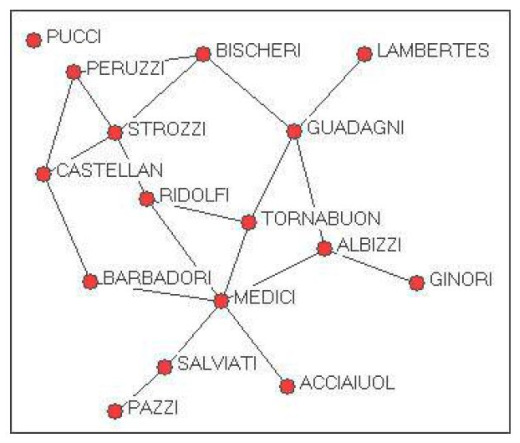

refrences:

pelegm-networkx.readthedocs.io. (n.d.). Creating a graph — NetworkX 2.0. documentation. [online] Available at: https://pelegm-networkx.readthedocs.io/en/latest/tutorial/tutorial.html#drawing-graphs [Accessed 7 Dec. 2022].

We recreate the graph diagram using networkx graph and then load it to neo4j database

All families are connected to using edges and the single nodes with  no edges represent no relation with other families

Connection to database is made using py2neo `Graph` method. We loop over the networkx graph to get nodes and edges for adding to database

Empty neo4j sandbox project is used for loading the database

In [ ]:
!pip install py2neo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 177 kB 4.4 MB/s 


Graph Representation using networkx:


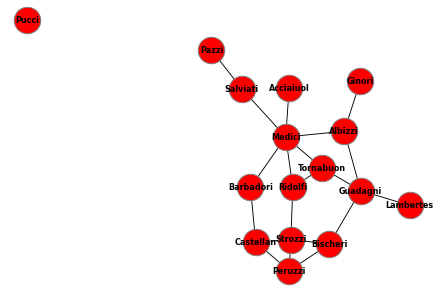

In [ ]:
import networkx as nx
from py2neo import Graph, Node, Relationship, NodeMatcher
import matplotlib.pyplot as plt

def florentine_families_ntwrk():
    """
    Recreate graph diagram using networkx Graph
    return Florentine families graph
    """
    G=nx.Graph()
    G.add_node('Pucci') # no family connections
    G.add_edge('Peruzzi','Strozzi')
    G.add_edge('Peruzzi','Bischeri')
    G.add_edge('Castellan','Peruzzi')
    G.add_edge('Castellan','Strozzi')
    G.add_edge('Castellan','Barbadori')
    G.add_edge('Medici','Barbadori')
    G.add_edge('Medici','Ridolfi')
    G.add_edge('Medici','Tornabuon')
    G.add_edge('Medici','Albizzi')
    G.add_edge('Medici','Salviati')
    G.add_edge('Medici','Acciaiuol')
    G.add_edge('Salviati','Pazzi')
    G.add_edge('Strozzi','Ridolfi')
    G.add_edge('Tornabuon','Ridolfi')
    G.add_edge('Strozzi','Bischeri')
    G.add_edge('Tornabuon','Guadagni')
    G.add_edge('Guadagni','Albizzi')
    G.add_edge('Guadagni','Bischeri')
    G.add_edge('Guadagni','Lambertes')
    G.add_edge('Albizzi','Ginori')

    return G

nx_graph = florentine_families_ntwrk()
print('Graph Representation using networkx:')
nx.draw(nx_graph, with_labels=True, node_color='red',node_size=700,width=0.9,font_size=8, font_weight="bold",edgecolors='gray')

In [ ]:
# create connection
host = '3.91.177.210'
port = '7687'
user = 'neo4j'
passw = 'validations-sights-laces'

graph = Graph('bolt://{}:{}'.format(host,port),  auth=(user, passw))

# clean graph database before use. 
# removes nodes,relationships and constraints
# added for sandbox with gds plugin.
graph.delete_all()
graph.run('CALL apoc.schema.assert({},{},true) YIELD label, key RETURN *')

# store networkx graph to neo4j db
def store_graph_to_db(neo_graph, nx_graph):
    '''
    Adds a NetworkX graph in Neo4J db
    All nodes are labeled "family"
    All edges have connection type "connection by marriage"
    
    Params
    ----------
    neo_graph: py2neo.database.Graph instance

    nx_graph: networkx.Graph instance
    '''
    matcher = NodeMatcher(neo_graph)

    for node in nx_graph.nodes():
      # Provides a label "family" to all nodes
      nd = Node('family', name = str(node))
      neo_graph.create(nd)
      
    for edge in nx_graph.edges():
      # print(edge)
      # Creates a relationship of "connection by marriage" for all edges
      n_edge0 = matcher.match("family", name=edge[0]).first()
      n_edge1 = matcher.match("family", name=edge[1]).first()
      neo_graph.create(Relationship(n_edge0, 'connection by marriage', n_edge1))

    return None

store_graph_to_db(graph, nx_graph)

Connect to database and get all nodes and relations in the db

In [ ]:
print('Nodes:')
for result in graph.run('MATCH (n) RETURN n;'):
    print(result)

print("="*30)
print('Relations:')
for result in graph.run('MATCH (n)-[r]->(m) RETURN n,r;'):
    print(result)

Nodes:
Node('family', name='Pucci')
Node('family', name='Peruzzi')
Node('family', name='Strozzi')
Node('family', name='Bischeri')
Node('family', name='Castellan')
Node('family', name='Barbadori')
Node('family', name='Medici')
Node('family', name='Ridolfi')
Node('family', name='Tornabuon')
Node('family', name='Albizzi')
Node('family', name='Salviati')
Node('family', name='Acciaiuol')
Node('family', name='Pazzi')
Node('family', name='Guadagni')
Node('family', name='Lambertes')
Node('family', name='Ginori')
Relations:
Node('family', name='Peruzzi')	connection by marriage(Node('family', name='Peruzzi'), Node('family', name='Castellan'))
Node('family', name='Peruzzi')	connection by marriage(Node('family', name='Peruzzi'), Node('family', name='Bischeri'))
Node('family', name='Peruzzi')	connection by marriage(Node('family', name='Peruzzi'), Node('family', name='Strozzi'))
Node('family', name='Strozzi')	connection by marriage(Node('family', name='Strozzi'), Node('family', name='Bischeri'))
Nod

### We calculate following measures of centrality: 
* Degree Centrality; 
* Closeness Centrality;
* Betweenness Centrality; 
* Eigenvector Centrality; 
* PageRank Centrality

for each node

In [ ]:
# calculate various centralities for every node
def get_centrality(graph):
    '''
    Computes and writes the degree of each node in Neo4J graph
    
    Params
    ---------
    graph: py2neo.database.Graph instance

    '''
        
    # check and drop graph for gds if it exists.
    graph_exists = graph.run("RETURN gds.graph.exists('florentine_graph') AS flrntGraphExists").data()
    if graph_exists[0]['flrntGraphExists'] == True:
      graph.run("CALL gds.graph.drop('florentine_graph')")

    # create named graph for graph catalog
    graph.run("""CALL gds.graph.project(
      'florentine_graph',
      'family',
      {`connection by marriage`:{orientation:'UNDIRECTED'}})"""
    )

    # calculate degree centrality for all nodes
    graph.run("""
    CALL gds.degree.write('florentine_graph', { writeProperty: 'degree', orientation: 'UNDIRECTED'})
    """)
    

    # calculate betweenness centrality
    graph.run("""
    CALL gds.betweenness.write('florentine_graph', { writeProperty: 'betweenness' })
    """)

    # calculate pagerank
    graph.run("""
    CALL gds.pageRank.write('florentine_graph', {
      maxIterations: 30,
      dampingFactor: 0.5,
      writeProperty: 'pagerank'
    })""")

    # calculate eigenvector centrality
    graph.run("""
    CALL gds.eigenvector.write('florentine_graph', { writeProperty: 'eigenvector' })
    """)

    # calculate closeness centrality
    graph.run("""
    CALL gds.beta.closeness.write('florentine_graph', { writeProperty: 'closeness' })
    """)
    
    return None


degre = get_centrality(graph)

In [ ]:
# get centralities for each node
graph.run("""Match (n:family) 
return 
n.name as name, 
n.closeness as closeness, 
n.betweenness as betweenness, 
n.pagerank as pagerank,
n.degree as degree, 
n.eigenvector as eigenvector
""").to_data_frame()

,name,closeness,betweenness,pagerank,degree,eigenvector
0,Pucci,0.000000,0.000000,0.500000,0.0,1.149684e-94
1,Peruzzi,0.368421,2.000000,0.975462,6.0,2.756048e-01
2,Strozzi,0.437500,9.333333,1.153486,8.0,3.558244e-01
3,Bischeri,0.400000,9.500000,0.976153,6.0,2.828059e-01
4,Castellan,0.388889,5.000000,1.011504,6.0,2.589153e-01
5,Barbadori,0.437500,8.500000,0.818963,4.0,2.118219e-01
6,Medici,0.560000,47.500000,1.804552,12.0,4.301415e-01
7,Ridolfi,0.500000,10.333333,0.957799,6.0,3.416433e-01
8,Tornabuon,0.482759,8.333333,0.979403,6.0,3.260546e-01
9,Albizzi,0.482759,19.333333,1.167022,6.0,2.442200e-01


### Families with higest centralities and observations


In [ ]:
# Adding helper functions for visualizing centralities

def get_centrality_plot(node_property, col_name=None):
  """
  Query and plot charts using the property value of node
  
  Params
  ---------
  node_property: property of node to query

  col_name: alias name to provide to node_property

  Returns
  -------
  matplotlib axes subplot, networkx graph diagram
  """
  col_name = node_property if col_name==None else col_name #col_name same as node property if none is passed to function
  node_name = graph.run("""Match (n:family) 
    return 
    n.name as name, 
    n.{} as {}
    order by n.{} desc
    """.format(node_property,col_name,node_property)).to_data_frame()

  node_name.plot.bar(x='name', y=col_name)
  plt.show()
  n = [node_name['name'][0],node_name['name'][1]] #get node with highest , second highest value
  print('Family with highest {} centrality:'.format(node_property))
  highlight_central_node(n)

def highlight_central_node(node_name):
  """
  draw graph with highlighted node with given node_name

  Params:
  ---------
  node_name: list of names matching with node.name property

  Returns
  -------
  networkx.graph diagram
  """
  node_sizes = [1400 if entry == node_name[0] else 1100 if entry == node_name[1] else 600 for entry in nx_graph.nodes]
  colors = ['lightblue' if  entry == node_name[0] else 'aliceblue' if  entry == node_name[1] else 'red' for entry in nx_graph.nodes]
  nx.draw(nx_graph, with_labels=True, node_color=colors,node_size=node_sizes,width=0.9,font_size=8, font_weight="bold",edgecolors='gray')

Below, we visualize the family with highest centralities.

**Note**: Here the degree centrality was calculated with `UNDIRECTED` orientation,i.e, sum of out-degree and in-degree centrality of each node was computed

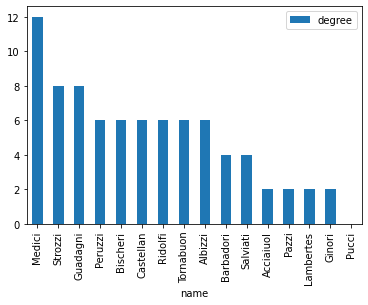

Family with highest degree centrality:


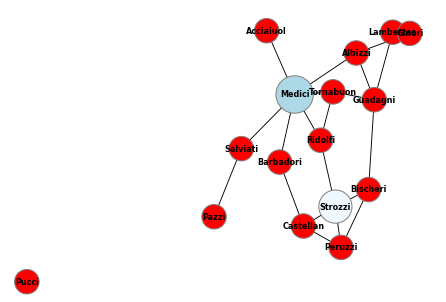

In [ ]:
get_centrality_plot('degree')

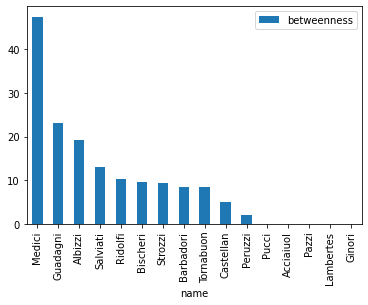

Family with highest betweenness centrality:


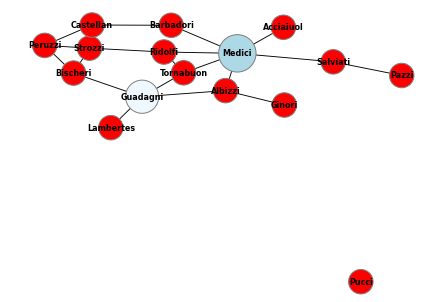

In [ ]:
get_centrality_plot('betweenness')

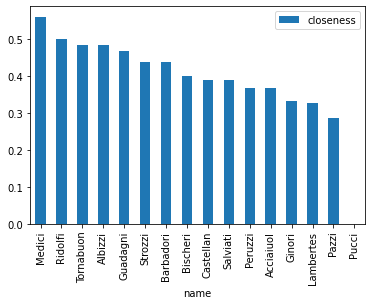

Family with highest closeness centrality:


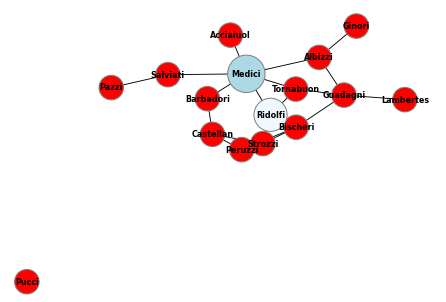

In [ ]:
get_centrality_plot('closeness')

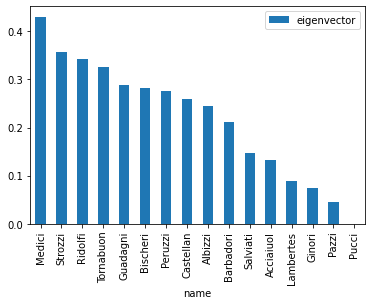

Family with highest eigenvector centrality:


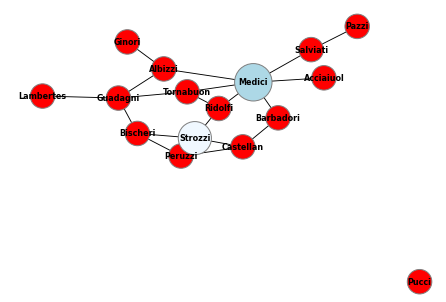

In [ ]:
get_centrality_plot('eigenvector')

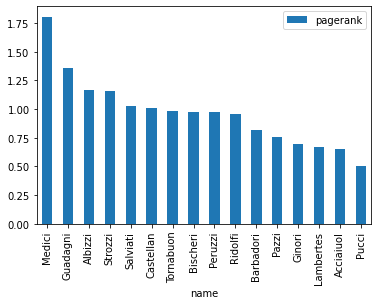

Family with highest pagerank centrality:


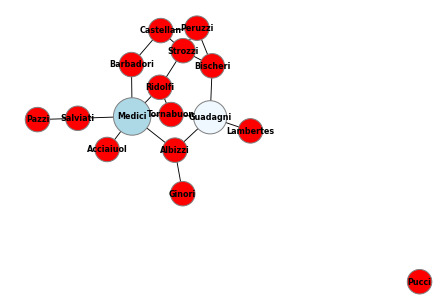

In [ ]:
get_centrality_plot('pagerank')